# 칼만필터는 어렵지 않아 따라하기

1. avg_filter
2. mov_avg_filter
3. low_pass_filter
4. simple_example

## 1. AVG_Filter
재귀식: 이전 결과를 재사용하여 값을 계산하는 식
재귀식 장점
- 이전 결과를 재사용하여 계산 효율이 좋음
- 데이터가 많을수록 계산량 차이가 늘어나는 경향(배치식과 비교하여)
- 메모리 저장공간 적게 차지함(이전 평균값, 추가 데이터, 데이터 개수)

필터 장점
- 쉽게 평균값 도출 가능
- 데이터가 순차적으로 입력될 경우 효과적임(시간에 따라서!)
- 평균을 취함으로써 잡음을 제거할 수 있음.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
def avg_filter(k, x_meas, x_avg):
    alpha = (k-1)/k
    x_avg = alpha * x_avg + (1 - alpha) * x_meas
    return x_avg

In [3]:
def get_volt():
    v = np.random.normal(0, 4)
    volt_mean = 14.4
    volt_meas = volt_mean + v
    return volt_meas

In [4]:
# 전체 시간과 측정 hz 정의
time_end = 10
dt = 0.2

In [5]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
x_meas_save = np.zeros(n_samples)
x_avg_save = np.zeros(n_samples)

In [7]:
x_avg = 0

for i in range(n_samples):
    k = i + 1
    x_meas = get_volt()
    x_avg = avg_filter(k, x_meas, x_avg)
    
    x_meas_save[i] = x_meas
    x_avg_save[i] = x_avg

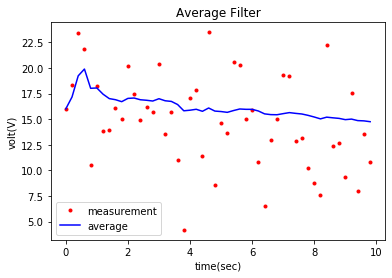

In [11]:
plt.plot(time, x_meas_save, 'r.', label='measurement')
plt.plot(time, x_avg_save, 'b', label='average')
plt.title('Average Filter')
plt.xlabel('time(sec)')
plt.ylabel('volt(V)')
plt.legend()
plt.show()

## Moving AVG Filter
이동평균 필터: 증권가에서 주로 사용

이동평균의 재귀식
- 평균을 취하면 데이터 잡음 제거는 가능. 하지만 측정하려는 물리량이 시간에 따라 변한다면, 전체 평균을 취하는 것은 적절치 않음.
- 전체 평균은 데이터의 동적인 변화를 없애기 때문
- 이동평균은 잡음을 없애는 동시에 시스템의 동적 변화를 반영함.
- 지정된 개수의 최근 측정값만 가지고 계산한 평균
- 새로 데이터가 들어오면 가장 오래된 데이터는 버리는 방식 취함. (큐)

이동평균 필터 함수
- 이동평균은 계산의 이점은 별로 없음.
- n개의 최근 데이터가 모두 보관되어야 하고, 입력마다 갱신되어야 하므로 메모리 공간절약 이점도 없음
- 배치식과 재귀식 모두 구현

In [13]:
def mv_avg_filter(x_n, x_meas):
    n = len(x_n)
    # 왼쪽으로 shift
    for i in range(n-1):
        x_n[i] = x_n[i+1]
    # 맨 마지막에 추가
    x_n[n-1] = x_meas
    x_avg = np.mean(x_n)
    return x_avg, x_n

In [14]:
from scipy import io
input_file = '../source/2.MovAvgFilter/SonarAlt.mat'
input_mat = io.loadmat(input_file)

In [15]:
def get_sonar(i):
    z = input_mat['sonarAlt'][0][i]
    return z

In [16]:
n = 10
n_samples = 500
time_end = 10

In [17]:
dt = time_end/ n_samples
time = np.arange(0, time_end, dt)
x_meas_save = np.zeros(n_samples)
x_avg_save = np.zeros(n_samples)

In [18]:
for i in range(n_samples):
    x_meas = get_sonar(i)
    if i == 0:
        x_avg, x_n = x_meas, x_meas * np.ones(n)
    else:
        x_avg, x_n = mv_avg_filter(x_n, x_meas)
    
    x_meas_save[i] = x_meas
    x_avg_save[i] = x_avg

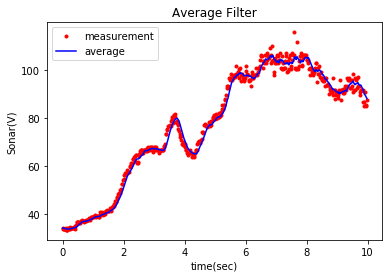

In [19]:
plt.plot(time, x_meas_save, 'r.', label='measurement')
plt.plot(time, x_avg_save, 'b', label='average')
plt.title('Average Filter')
plt.xlabel('time(sec)')
plt.ylabel('Sonar(V)')
plt.legend()
plt.show()

## 3. Low-pass filter
저주파 통과 필터

이동평균의 한계
- 모든데이터에 **동일가중치** 부여함
- 최신 측정값(데이터)이 현재값과 비슷할 가능성이 높으나, **오래된 데이터와 동일 가중치 처리**
- 이동평균필터를 사용할 때는 장점과 한계 정확히 알고 적재적소 적용하는 것이 중요

1차 저주파 통과 필터
- 최근 측정값에는 높은 가중치, 오래된 값에는 낮은 가중치를 주는 필터
- 재귀식
    - alpha는 0~1인 임의의 상수
    - 저주파 통과 필터의 x hat k 는 평균과 관련없음, '추정값' 이라는 용어로 사용
    - 더 오래된 값에 더 낮은 가중치 부여함
- 측정 데이터에 곱해진 계수 a * (1 - a)와 (1 - a) 크기 비교
- 지수가중(exponentially weighted) 필터라고도 부름

In [25]:
def low_pass_filter(x_meas, x_esti):
    x_esti = alpha * x_esti + (1 - alpha) * x_meas
    return x_esti

In [34]:
# Change Alpha!
alpha = 0.9
n_samples = 500
time_end = 10

In [35]:
dt = time_end / n_samples
time = np.arange(0, time_end, dt)
x_meas_save = np.zeros(n_samples)
x_esti_save = np.zeros(n_samples)

In [36]:
x_esti = None
for i in range(n_samples):
    x_meas = get_sonar(i)
    if i == 0:
        x_esti = x_meas
    else:
        x_esti = low_pass_filter(x_meas, x_esti)
    
    x_meas_save[i] = x_meas
    x_esti_save[i] = x_esti

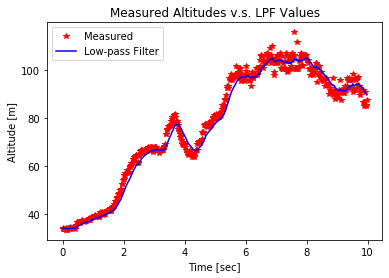

In [37]:
plt.plot(time, x_meas_save, 'r*', label='Measured')
plt.plot(time, x_esti_save, 'b-', label='Low-pass Filter')
plt.legend(loc='upper left')
plt.title('Measured Altitudes v.s. LPF Values')
plt.xlabel('Time [sec]')
plt.ylabel('Altitude [m]')
plt.show()

## Kalman Filter

In [57]:
def get_volt():
    """Measure voltage"""
    v = np.random.normal(0,4)     # v: measurement noise
    volt_true = 14.4              # volt_true: True voltage
    z_volt_meas = volt_true + v   # z_volt_meas: Measured Voltage[V] (observable)
    return z_volt_meas

In [58]:
# Initialization system model
A = 1
H = 1
Q = 0
R = 4

def kalman_filter(z_meas, x_esti, P):
    global A, H, Q, R
    """Kalman Filter Algorithm for One Variable"""
    # (1) Prediction
    x_pred = A * x_esti
    P_pred = A * P * A + Q
    
    # (2) Kalman Gain
    K = P_pred * H / (H * P_pred * H + R)
    
    # (3) Estimation
    x_esti = x_pred + K * (z_meas - H * x_pred)
    
    # (4) Error Covariance
    P = P_pred - K * H * P_pred
    
    return x_esti, P

In [59]:
time_end = 10
dt = 0.2

In [60]:
# Initialization for estimation
x_0 = 10
P_0 = 6

In [61]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
volt_meas_save = np.zeros(n_samples)
volt_esti_save = np.zeros(n_samples)

In [62]:
x_esti,P = None, None

for i in range(n_samples):
    z_meas = get_volt()
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)
    
    volt_meas_save[i] = z_meas
    volt_esti_save[i] = x_esti

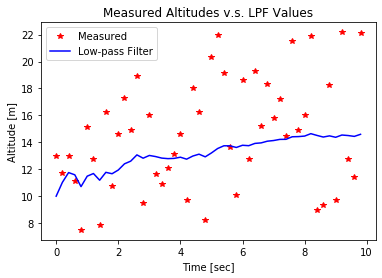

In [63]:
plt.plot(time, volt_meas_save, 'r*', label='Measured')
plt.plot(time, volt_esti_save, 'b-', label='Low-pass Filter')
plt.legend(loc='upper left')
plt.title('Measured Altitudes v.s. LPF Values')
plt.xlabel('Time [sec]')
plt.ylabel('Altitude [m]')
plt.show()